In [2]:
%matplotlib inline
import os
import sys
sys.path.append('/root/capsule/aind-beh-ephys-analysis/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar,merge_pdfs
from session_preprocessing import ephys_opto_preprocessing
from opto_tagging import opto_plotting_session
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression

from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
# def load_motion_info(folder):
from spikeinterface.preprocessing.motion import load_motion_info

 
# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

In [3]:
session = 'behavior_751004_2024-12-19_11-50-37'
session_dir = session_dirs(session)

In [4]:
# ephys_opto_preprocessing(session, 'curated', 'soma')

In [5]:
motion_info = load_motion_info(f'/root/capsule/data/{session}_sorted/preprocessed/motion/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1')

In [6]:
# sampling
bin_sampling = 10
temp_bins_sampling = np.arange(motion_info['motion'].temporal_bins_s[0][0], motion_info['motion'].temporal_bins_s[0][-1], bin_sampling)
probe_location = np.linspace(2500, 0,  96)

drift_sampling = np.zeros(shape=(len(probe_location), len(temp_bins_sampling)))
for i, t in enumerate(temp_bins_sampling): 
    for j, p in enumerate(probe_location):
        drift_sampling[j, i] = motion_info['motion'].get_displacement_at_time_and_depth([t], [p])

/tmp/ipykernel_19782/2911619925.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  drift_sampling[j, i] = motion_info['motion'].get_displacement_at_time_and_depth([t], [p])


In [7]:
# fast dynamics
bin_short = 100
temp_bins = np.arange(motion_info['motion'].temporal_bins_s[0][0], motion_info['motion'].temporal_bins_s[0][-1], bin_short)
drift = np.zeros(shape=(len(probe_location), len(temp_bins)))

drift = np.full((len(probe_location), len(temp_bins)), np.nan)
for i, t in enumerate(temp_bins): 
    for j, p in enumerate(probe_location):
        curr_ind = np.where((temp_bins_sampling >= t-bin_short/2) & (temp_bins_sampling < t+bin_short/2))[0]
        if curr_ind.size > 0:
            drift[j, i] = np.mean(drift_sampling[j, curr_ind])



In [52]:
# slow dynamics
bin_long = 300 # seconds
temp_bins_slow = temp_bins

drift_slow_pre = np.full((len(probe_location), len(temp_bins_slow)), np.nan)
drift_slow_post = np.full((len(probe_location), len(temp_bins_slow)), np.nan)
drift_slow = np.full((len(probe_location), len(temp_bins_slow)), np.nan)
for i, t in enumerate(temp_bins_slow): 
    for j, p in enumerate(probe_location):
        curr_ind = np.where((temp_bins_sampling >= t-bin_long) & (temp_bins_sampling < t))[0]
        if curr_ind.size > 0:
            drift_slow_pre[j, i] = np.mean(drift_sampling[j, curr_ind])
        curr_ind = np.where((temp_bins_sampling > t) & (temp_bins_sampling <= t+bin_long))[0]
        if curr_ind.size > 0:
            drift_slow_post[j, i] = np.mean(drift_sampling[j, curr_ind])
        curr_ind = np.where((temp_bins_sampling >= t-bin_long/2) & (temp_bins_sampling <= t+bin_long/2))[0]
        if curr_ind.size > 0:
            drift_slow[j, i] = np.mean(drift_sampling[j, curr_ind])
drift_slow_pre[:,0] = drift_slow_pre[:,1]
drift_slow_post[:,-1] = drift_slow_post[:,-2]

Text(0.5, 1.0, 'Fast drift - slow drift')

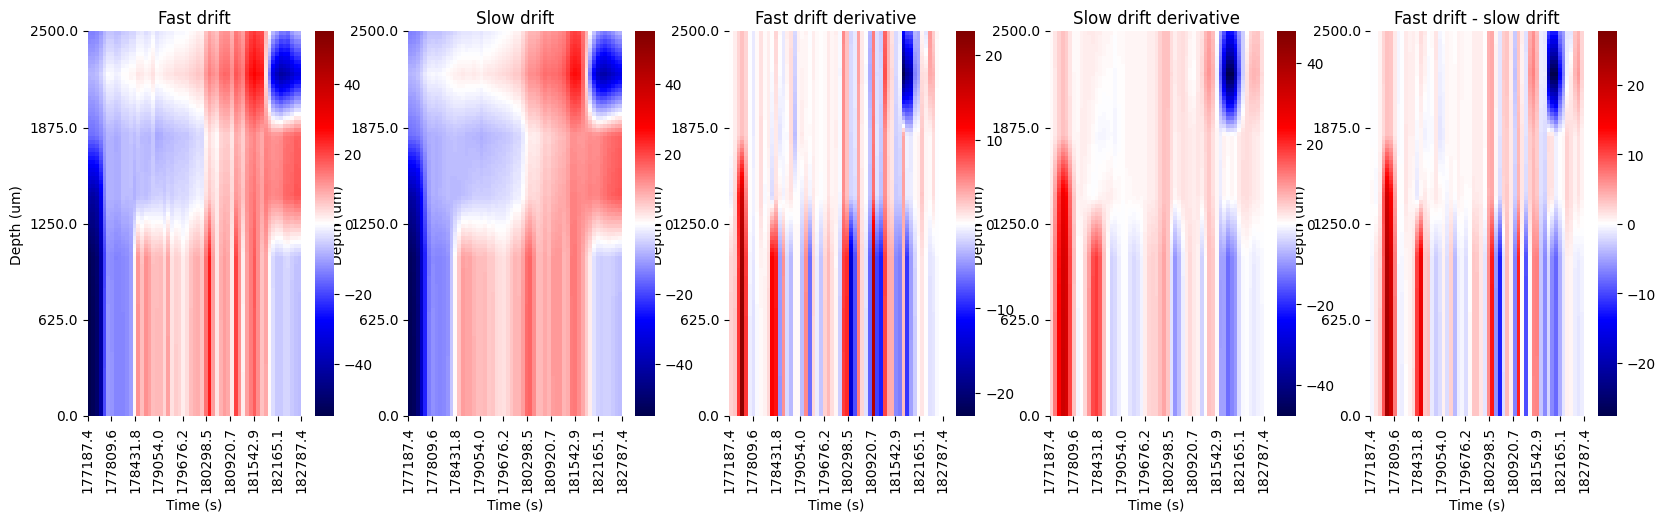

In [54]:
range_max = np.max(np.abs(drift))
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
plt.subplot(1, 5, 1)
sns.heatmap(drift, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins[0], temp_bins[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift')

plt.subplot(1, 5, 2)
sns.heatmap(drift_slow, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Slow drift')

plt.subplot(1, 5, 3)
range_max = np.max(np.abs(np.diff(drift)))
sns.heatmap(np.diff(drift), cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins[0], temp_bins[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift derivative')

range_max = np.max(np.abs(drift_slow_post - drift_slow_pre))
plt.subplot(1, 5, 4)
sns.heatmap(drift_slow_post - drift_slow_pre, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Slow drift derivative')

drift_diff = drift - drift_slow_pre
range_max = np.max(np.abs(drift_diff))
plt.subplot(1, 5, 5)
sns.heatmap(drift_diff, cmap='seismic', center=0, vmin=-range_max, vmax=range_max)
plt.xticks(np.linspace(0, len(temp_bins_slow), 10), [f"{x:.1f}" for x in list(np.linspace(temp_bins_slow[0], temp_bins_slow[-1], 10))]);
plt.yticks(np.linspace(0, len(probe_location), 5), [f"{x:.1f}" for x in list(np.linspace(probe_location[0], probe_location[-1], 5))]);
plt.xlabel('Time (s)')
plt.ylabel('Depth (um)')
plt.title('Fast drift - slow drift')

In [10]:
unit_tbl = opto_plotting_session(session, 'curated', 'soma', plot=False, resp_thresh=0.3, lat_thresh=0.025) 

/root/capsule/code/beh_ephys_analysis/opto_tagging.py:352: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  unit_qc = unit_qc.apply(pd.to_numeric, errors='ignore')


91 out of 267 units pass quality control
{'samples_to_keep': [-30, 60], 'y_neighbors_to_keep': 3, 'orginal_loc': False}
PDF files in '/root/capsule/scratch/751004/behavior_751004_2024-12-19_11-50-37/ephys/opto/curated/figures' merged into '/root/capsule/scratch/751004/behavior_751004_2024-12-19_11-50-37/ephys/opto/curated/behavior_751004_2024-12-19_11-50-37_opto_tagging.pdf' successfully.
10 out of 267 units pass quality control and opto tagging


In [11]:
unit_tbl

,unit_id,resp_p,resp_lat,powers,sites,num_pulses,durations,freqs,stim_times,opto_pass,...,ks_unit_id,isi_violations_ratio,firing_rate,presence_ratio,amplitude_cutoff,decoder_label,depth,euclidean_norm,correlation,default_qc
0,0,None,None,None,None,None,None,None,None,False,...,0,0.000000,0.072709,0.808511,NaN,mua,170.43,NaN,NaN,False
1,1,None,None,None,None,None,None,None,None,False,...,1,0.486594,0.918804,0.872340,0.000383,mua,3.40,NaN,NaN,False
2,2,[0.72],[0.011866555440285469],[50],[surface_LC],[5],[5],[5],[post],True,...,2,0.048411,4.799117,1.000000,0.000168,sua,78.83,[None],[None],True
3,3,"[0.9, 0.9, 0.7, 0.65, 0.8]","[0.0108739817788934, 0.011918291425293622, 0.0...","[10, 20, 30, 40, 50]","[surface_LC, surface_LC, surface_LC, surface_L...","[5, 5, 5, 5, 5]","[4, 4, 4, 4, 4]","[5, 5, 5, 5, 5]","[post, post, post, post, post]",True,...,3,0.074913,10.321623,1.000000,0.000033,sua,94.24,"[None, None, None, None, None]","[None, None, None, None, None]",True
4,5,None,None,None,None,None,None,None,None,False,...,5,0.000326,60.011850,1.000000,0.000288,sua,160.25,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,295,None,None,None,None,None,None,None,None,False,...,295,0.000000,0.032921,0.744681,NaN,mua,1482.47,NaN,NaN,False
263,296,[0.45],[0.01557137987886866],[50],[surface_LC],[5],[4],[5],[post],True,...,296,0.081666,2.397622,1.000000,0.000098,mua,285.57,[None],[None],True
264,297,"[0.45, 0.6, 0.7, 0.7, 0.65]","[0.015947510378383514, 0.010918277435121127, 0...","[20, 30, 30, 40, 50]","[surface_LC, surface_LC, surface_LC, surface_L...","[5, 5, 5, 5, 5]","[4, 4, 4, 4, 4]","[5, 5, 5, 5, 5]","[post, post, pre, post, post]",True,...,297,0.042272,2.040769,1.000000,0.000446,sua,442.97,"[None, None, None, None, None]","[None, None, None, None, None]",True
265,298,"[0.55, 0.5, 0.55, 0.55]","[0.01620521015932106, 0.016074350674171, 0.013...","[30, 30, 40, 50]","[surface_LC, surface_LC, surface_LC, surface_LC]","[5, 5, 5, 5]","[4, 4, 4, 4]","[5, 5, 5, 5]","[post, pre, post, post]",True,...,298,0.028097,3.540009,1.000000,0.000093,noise,455.52,"[None, None, None, None]","[None, None, None, None]",False


In [12]:
sorting_analyzer = si.load_sorting_analyzer(session_dir['postprocessed_dir_curated']) 
sorting = si.load_extractor(session_dir['curated_dir_curated'])

In [13]:
unit_locations = sorting_analyzer.get_extension('unit_locations').get_data(outputs="by_unit")
spike_amplitudes = sorting_analyzer.get_extension('spike_amplitudes').get_data(outputs="by_unit")[0]
unit_ids = sorting.get_unit_ids()

In [14]:
spike_pcs = sorting_analyzer.get_extension('principal_components')

In [15]:
spike_pcs.get_projections_one_unit(10)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

  

In [79]:
def plot_drift(unit_id):
    spike_times = unit_tbl[unit_tbl['unit_id'] == unit_id]['spike_times'].values[0]
    spike_amplitude = spike_amplitudes[unit_id]
    # firing rate
    temp_bins_spike = np.zeros(len(temp_bins)+1)
    temp_bins_spike[1:] = temp_bins+bin_short/2
    temp_bins_spike[0] = temp_bins[0] - bin_short/2
    temp_bins_slow_spike = temp_bins_slow
    spike_counts_fast, _ = np.histogram(spike_times, bins=temp_bins_spike)
    spike_counts_fast = spike_counts_fast/bin_short
    spike_counts_slow_pre = np.full(len(temp_bins_slow_spike), np.nan)
    spike_counts_slow_post = np.full(len(temp_bins_slow_spike), np.nan)
    spike_counts_slow = np.full(len(temp_bins_slow_spike), np.nan)
    for i, t in enumerate(temp_bins_slow_spike):
        if t - bin_long - bin_short/2 > temp_bins[0] - bin_short/2:
            spike_counts_slow_pre[i] = np.sum((spike_times >= t - bin_long - bin_short/2) & (spike_times < t-bin_short/2))
            spike_counts_slow_pre[i] = spike_counts_slow_pre[i] / bin_long
        if t + bin_short/2 + bin_long < temp_bins[-1] + bin_short/2:
            spike_counts_slow_post[i]= np.sum((spike_times >= t + bin_short/2) & (spike_times < t + bin_short/2 + bin_long))
            spike_counts_slow_post[i] = spike_counts_slow_post[i] / bin_long
        if t - bin_long/2 > temp_bins[0] - bin_short/2 and t + bin_long/2 < temp_bins[-1] + bin_short/2:
            spike_counts_slow[i] = np.sum((spike_times >= t - bin_long/2) & (spike_times < t + bin_long/2))
            spike_counts_slow[i] = spike_counts_slow[i] / bin_long
        

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 3)
    ax = plt.subplot(gs[0, 0])
    plt.hist(spike_times, bins=temp_bins);
    plt.title(f'y loc {unit_locations[unit_id][1] :.2f} um')


    ax = plt.subplot(gs[1, 0])
    plt.plot(temp_bins, spike_counts_fast, label='fast firing rate')
    plt.plot(temp_bins_slow_spike, spike_counts_slow, label='slow firing rate', c = 'r')

    ax = plt.subplot(gs[2, 0])
    plt.plot(temp_bins, (spike_counts_fast-spike_counts_slow_pre)/(0.5*(spike_counts_fast+spike_counts_slow_pre)), label='drift')
    ax = ax.twinx()
    plt.plot(temp_bins_slow_spike, (spike_counts_slow_post - spike_counts_slow_pre)/(0.5*(spike_counts_slow_pre + spike_counts_slow_post)), label = 'slow', c='r')
    plt.legend()

    ax = plt.subplot(gs[3, 0])
    plt.plot(temp_bins, np.abs(spike_counts_fast - spike_counts_slow_pre)/(0.5*(spike_counts_fast+spike_counts_slow_pre)), label='drift')
    plt.plot(temp_bins_slow_spike, np.abs(spike_counts_slow_post - spike_counts_slow_pre)/(0.5*(spike_counts_slow_pre + spike_counts_slow_post)), label = 'slow', c='r')
    

    # drift
    closest_ybin = np.argmin(np.abs(probe_location - unit_locations[unit_id][1]))
    ax = plt.subplot(gs[1, 1])
    plt.plot(temp_bins, drift[closest_ybin, :], label='drift')
    plt.plot(temp_bins_slow, drift_slow[closest_ybin, :], label='slow drift', c = 'r')
    plt.plot(temp_bins, np.zeros(len(temp_bins)), 'k--')
    # plt.plot(motion_info['motion'].get_displacement_at_time_and_depth(times_s, locations_um))
    ax = plt.subplot(gs[2, 1])
    plt.plot(temp_bins, (drift[closest_ybin, :] - drift_slow[closest_ybin,:]), label='drift')
    plt.plot(temp_bins, drift_slow_post[closest_ybin, :] - drift_slow[closest_ybin,:], label='slow drift', c = 'r')
    plt.legend()


    ax = plt.subplot(gs[3, 1])
    plt.plot(temp_bins, np.abs(drift[closest_ybin, :] - drift_slow[closest_ybin,:]), label='drift')
    plt.plot(temp_bins, np.abs(drift_slow_post[closest_ybin, :] - drift_slow[closest_ybin,:]), label='slow drift', c = 'r')

    # amplitude
    amplitude_fast = np.full((len(temp_bins)), np.nan)
    amplitude_slow_pre = np.full((len(temp_bins_slow)), np.nan)
    amplitude_slow_post = np.full((len(temp_bins_slow)), np.nan)
    amplitude_slow = np.full((len(temp_bins)), np.nan)
    for i, t in enumerate(temp_bins):
        inds = np.where((spike_times >= t-bin_short) & (spike_times < t+bin_short))[0]
        if inds.size > 5:
            temp = spike_amplitude[inds]
            cut_off = np.percentile(temp, [5, 95])
            temp = temp[(temp >= cut_off[0]) & (temp <= cut_off[1])]
            if temp.size > 0:
                amplitude_fast[i] = np.mean(temp)

    for i, t in enumerate(temp_bins_slow):
        inds = np.where((spike_times >= t-bin_long - bin_short) & (spike_times < t - bin_short))[0]
        if inds.size > 5:
            temp = spike_amplitude[inds]
            cut_off = np.percentile(temp, [5, 95])
            temp = temp[(temp >= cut_off[0]) & (temp <= cut_off[1])]
            if temp.size > 0:
                amplitude_slow_pre[i] = np.mean(temp)
        inds = np.where((spike_times >= t + bin_short) & (spike_times < t + bin_short + bin_long))[0]
        if inds.size > 5:
            temp = spike_amplitude[inds]
            cut_off = np.percentile(temp, [5, 95])
            temp = temp[(temp >= cut_off[0]) & (temp <= cut_off[1])]
            if temp.size > 0:
                amplitude_slow_post[i] = np.mean(temp)
        
        inds = np.where((spike_times >= t-bin_long/2) & (spike_times < t+bin_long/2))[0]
        if inds.size > 5:
            temp = spike_amplitude[inds]
            cut_off = np.percentile(temp, [5, 95])
            temp = temp[(temp >= cut_off[0]) & (temp <= cut_off[1])]
            if temp.size > 0:
                amplitude_slow[i] = np.mean(temp)



    ax = plt.subplot(gs[0, 2])
    plt.scatter(spike_times, spike_amplitude, c='k', s=0.5, alpha=0.25)


    ax = plt.subplot(gs[1, 2])
    plt.plot(temp_bins, amplitude_fast, label='fast amplitude')
    plt.plot(temp_bins, amplitude_slow, label='slow amplitude', c = 'r')

    ax = plt.subplot(gs[2, 2])
    plt.plot(temp_bins, amplitude_fast - amplitude_slow_pre, label='amplitude drift')
    ax = ax.twinx()
    plt.plot(temp_bins_slow, amplitude_slow_post - amplitude_slow_pre, label='slow drift', c='r')
    
    ax = plt.subplot(gs[3, 2])
    plt.plot(temp_bins, np.abs(amplitude_fast - amplitude_slow_pre), label='drift')
    plt.plot(temp_bins_slow, np.abs(amplitude_slow_post - amplitude_slow_pre), label = 'slow', c='r')

    from sklearn.linear_model import LinearRegression

    # # Combine x and y into a feature matrix
    X = np.column_stack((drift_slow[closest_ybin], amplitude_slow))

    # Create and fit the linear regression model
    model = LinearRegression()
    nan_inds = np.where(~np.isnan(spike_counts_slow) & np.all(~np.isnan(X), axis=1))[0]

    model.fit(X[nan_inds], spike_counts_slow[nan_inds])
    r_squared = model.score(X[nan_inds], spike_counts_slow[nan_inds])


    ax = plt.subplot(gs[4, 0])
    plt.plot(temp_bins, spike_counts_slow, label='data', c='r')
    plt.plot(temp_bins, model.predict(X), label='model', c='b')
    plt.legend()
    plt.title(f"R² score: {r_squared:.2f}")

    # # Print coefficients and intercept
    # print(f"Coefficients: {model.coef_}")
    # print(f"Intercept: {model.intercept_}")

    # # Predict new values
    # X_new = np.array([[6, 7], [7, 8]])
    # z_pred = model.predict(X_new)
    # print(f"Predicted values: {z_pred}")
    ax = plt.subplot(gs[4, 1])
    plt.hist(spike_counts_slow, bins=20, alpha=0.5, label='data', color='r')
    sd = np.std(spike_counts_slow[nan_inds])/np.nanmean(spike_counts_slow)
    plt.title(f"SD/mean: {sd:.2f}")

    plt.suptitle(unit_id)
    plt.tight_layout()

    return {'unit_id': unit_id, 'r_squared_slow': r_squared, 'sd/mean': sd}

In [23]:
units_to_plot = []
p_thresh = 0.4
lat_thresh = 0.02
for i, row in unit_tbl.iterrows():
    if row['resp_p'] is not None:
        opto_pass = len(np.where((np.array(row['resp_p']) > p_thresh) & (np.array(row['resp_lat']) < lat_thresh) & (np.array(row['resp_lat']) > 0.004))[0]) > 0
        quality_pass = (row['isi_violations_ratio'] < 0.05) & (row['decoder_label'] != 'noise') & (row['decoder_label'] != 'artifact')
        if opto_pass & quality_pass:
            if np.where(np.array(row['resp_p']) > p_thresh)[0].size > 0:
                units_to_plot.append(row['unit_id'])

In [4]:
for unit in units_to_plot:                             
    plot_drift(unit)
    plt.show()

NameError: name 'units_to_plot' is not defined

Random Forest R² Score: 0.9729


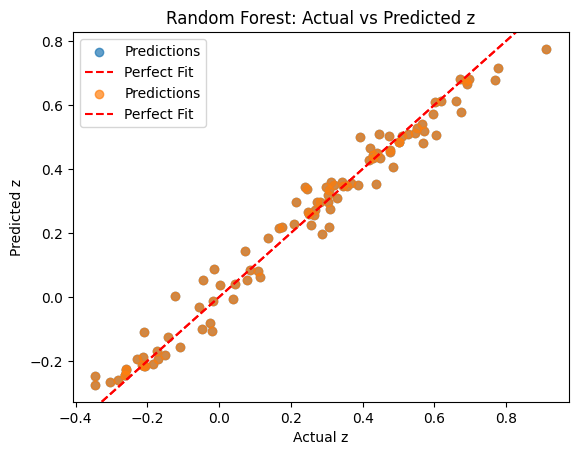

Feature Importance - x: 0.1453, y: 0.8547


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Generate synthetic data
np.random.seed(42)
n = 100
x = np.sin(np.linspace(0, 10, n)) + np.random.normal(0, 0.1, n)  # Feature x
y = np.cos(np.linspace(0, 10, n)) + np.random.normal(0, 0.1, n)  # Feature y
z = 0.5 * x**2 + 0.3 * np.sin(y) + np.random.normal(0, 0.1, n)  # Non-linear relationship

# Feature matrix
X = np.column_stack((x, y))

# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X, z)

# Predictions
z_pred_rf = model_rf.predict(X)

# Evaluate model
r2_rf = r2_score(z, z_pred_rf)
print(f"Random Forest R² Score: {r2_rf:.4f}")

# Plot actual vs predicted values
plt.scatter(z, z_pred_rf, alpha=0.7, label="Predictions")
plt.xlabel("Actual z")
plt.ylabel("Predicted z")
plt.title("Random Forest: Actual vs Predicted z")
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Perfect Fit")
plt.legend()
plt.show()

# Feature Importance
importances = model_rf.feature_importances_
print(f"Feature Importance - x: {importances[0]:.4f}, y: {importances[1]:.4f}")
